In [7]:
###O-C Diagram and necessary data tables
##Make sure you change the directory of the downloaded data files or comment it out for this to run properly
##For every Object we will have to change the period, and the initial guesses manually

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import lightkurve as lk
from scipy.optimize import curve_fit
import pandas as pd

TIC = 'TIC 3034524'

data_all = lk.search_lightcurve(TIC, author='SPOC')

data = data_all[0]

lc = data.download_all().stitch()

In [8]:
# Define the Gaussian function
def gaussian_function(x, A, mu, sigma):
    return -(A * np.exp(-((x - mu)**2) / (2 * sigma**2))-1)

def process_chunk(start_index, end_index, mu_fit):
    Times = lc.time[start_index:end_index]
    t = Time(Times)
    x = np.array(t.btjd)
    y = np.array(lc.flux[start_index:end_index])
    
    # Remove invalid values (infs and NaNs) from y and x arrays
    mask_valid = ~np.isnan(y) & ~np.isinf(y)
    x = x[mask_valid]
    y = y[mask_valid]
    
    while len(x) > 3:
        # Fitting the curve to the data
        initial_guess = [A_guess, mu_fit, sigma_guess]
        try:
            params, covariance = curve_fit(gaussian_function, x, y, p0=initial_guess)
            
            # Get fitted values for A, μ and σ
            A_fit, mu_fit, sigma_fit = params
            
            # Get the diagonals of the covariance matrix as the variances of A, μ and σ
            var_A_fit, var_mu_fit, var_sigma_fit = np.diag(covariance)
            
            # Check variances and calculate errors, or assign default value if variance is too small
            min_variance_threshold = 1e-10  # Adjust this threshold as needed
            error_A_fit = np.sqrt(var_A_fit) 
            error_mu_fit = np.sqrt(var_mu_fit) 
            error_sigma_fit = np.sqrt(var_sigma_fit)
            
            # Convert to numpy array for efficient operations
            error_mu_fit = np.array(error_mu_fit)
            
            # Find indices where values are inf and replace them with np.nan
            inf_indices = np.isinf(error_mu_fit)
            error_mu_fit[inf_indices] = np.nan
    
            mu_fit_values.append(mu_fit)
            error_mu_fit_values.append(error_mu_fit)
            
        except RuntimeError:
            # Handle cases where curve_fit fails to converge
            print("Curve fitting failed to converge")
            return mu_fit  # or handle this case as needed

        return mu_fit

    if len(x) <= 3:
        mu_guess= 1829
        initial_guess = [A_guess, mu_guess, sigma_guess]
        mu_fit = initial_guess[1]

        return mu_fit

# Define initial guesses for A, mu, and sigma
A_guess = 10
mu_guess = 1816.3
sigma_guess = 0.17

# Create the initial_guess list
initial_guess = [A_guess, mu_guess, sigma_guess]

# Get the period in julian days
period_julian_days = 0.36

# Initialize mu_fit with the initial guess value for mu
mu_fit = initial_guess[1]

# Initialize lists for mu_fit and error_mu_fit values
mu_fit_values = []
error_mu_fit_values = []

# Iterate through the light curve and process chunks of data with the given period
start_index = 0
i=1
while start_index < len(lc):
    end_time = lc.time[start_index] + period_julian_days
    end_index = np.searchsorted(lc.time, end_time, side='right')
    
    # Call process_chunk with the updated mu_fit value
    mu_fit = process_chunk(start_index, end_index, mu_fit)
    mu_fit = mu_fit + period_julian_days
    
    # Update the start_index for the next iteration
    start_index = end_index
    i=i+1 

#Print O values data table 

o_values = mu_fit_values
o_values_errors = error_mu_fit_values
df = pd.DataFrame({'O Values': o_values, 'O Values Errors': o_values_errors})
#df = df["O Values Errors"].replace(np.Inf, np.nan).mean(skipna=True)

### I have to iterate through all of this 
# Given observed times (O) of minima for an eclipsing binary
observed_times = np.array(o_values)

T0 = mu_fit_values [0]  # The first mu_fit is T0
P = 0.3574530753 # Period of the eclipsing binar

# Calculate the epoch (E) for each mu_fit (O) value
epochs = np.round((mu_fit_values - T0) / P)

# Calculate the calculated times (C) using the linear ephemeris model
calculated_times = T0 + P * epochs

# Calculate the O-C values
oc_values = mu_fit_values - calculated_times

# Create a DataFrame to store the results
oc_data_table = pd.DataFrame({'mu_fit': mu_fit_values,'Epochs': epochs,'Calculated Times': calculated_times,'O-C Values': oc_values})

# Display the O-C DataFrame
print(df)
print(oc_data_table)
# Save the DataFrame to a CSV file
#path1 = '/Users/valegarcia/Downloads/oc_data_table.csv'
#path2 = '/Users/valegarcia/Downloads/df.csv'
#oc_data_table.to_csv(path1, index=False)
#df.to_csv(path2, index=False)

       O Values        O Values Errors
0   1816.367468  0.0015581582820616518
1   1816.723548  0.0009906824826906365
2   1817.083116   0.001252283470567065
3   1817.440023  0.0011959638541932602
4   1817.795756  0.0011550001158974865
..          ...                    ...
62  1839.601761  0.0014186559615861675
63  1839.962298  0.0012374857242301407
64  1840.319380   0.001337148447036128
65  1840.675441   0.001502308235290981
66  1841.033580   0.004364568587968365

[67 rows x 2 columns]
         mu_fit  Epochs  Calculated Times  O-C Values
0   1816.367468     0.0       1816.367468    0.000000
1   1816.723548     1.0       1816.724921   -0.001373
2   1817.083116     2.0       1817.082374    0.000742
3   1817.440023     3.0       1817.439827    0.000196
4   1817.795756     4.0       1817.797280   -0.001524
..          ...     ...               ...         ...
62  1839.601761    65.0       1839.601918   -0.000157
63  1839.962298    66.0       1839.959371    0.002927
64  1840.319380    67.0

In [9]:
# Fit a linear model to the O-C values vs. epochs
def linear_model(x, a):
    return a * x

params, covariance = curve_fit(linear_model, epochs, oc_values)


# The slope of the linear fit represents P-dot (dP/dt)
p_dot = params[0]

# Print the calculated P-dot value
print(f"Calculated P-dot: {p_dot}")

Calculated P-dot: -1.7623060361904308e-05


Best fit equation:
y = [ 2.44212115e-04 -4.48495993e-01]*x^0 + [ 2.44212115e-04 -4.48495993e-01]*x^1


<IPython.core.display.Javascript object>


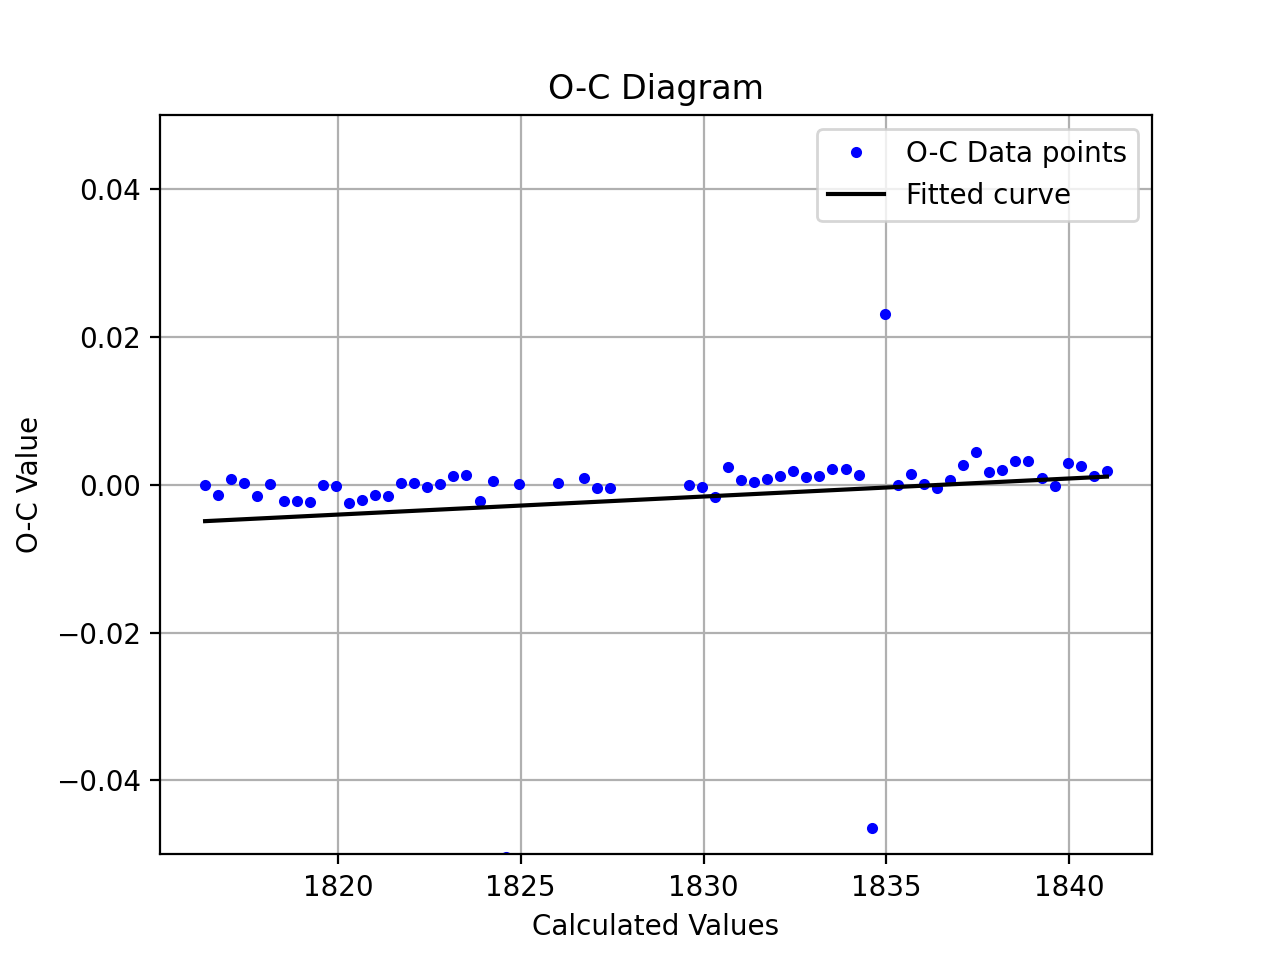

/var/folders/z0/kkt653vs1rscq9_7hh77yyyr0000gn/T/ipykernel_6524/1039855451.py:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(x, y, 'ro', label='O-C Data points', marker='.', color='b')
/var/folders/z0/kkt653vs1rscq9_7hh77yyyr0000gn/T/ipykernel_6524/1039855451.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, y, 'ro', label='O-C Data points', marker='.', color='b')


In [10]:
def graph():
    import numpy as np
    import matplotlib.pyplot as plt
    from numpy.polynomial.polynomial import Polynomial

    #data points
    x = np.array(calculated_times)
    y = np.array(oc_values)

    # Fit a polynomial curve
    degree = 1
    coefs = np.polyfit(x, y, degree)

    # Create a polynomial
    p = Polynomial(coefs[::-1])  

    # Print the curve equation
    equation = f"y = {' + '.join(f'{coefs}*x^{i}' for i, coef in enumerate(coefs[::-1]))}"
    print("Best fit equation:")
    print(equation)

    # Plotting
    xp = np.linspace(min(x), max(x), 100)
    plt.ylim([-0.05, 0.05])
    plt.plot(x, y, 'ro', label='O-C Data points', marker='.', color='b')
    plt.plot(xp, p(xp), '-', label='Fitted curve', color='black')
    plt.xlabel('Calculated Values')
    plt.ylabel('O-C Value')
    plt.title('O-C Diagram')
    plt.legend()
    plt.grid(True)
    plt.show()
    
graph()
